# Vanilla sparse coding tutorial notebook
Basic sparse coding implemented with Euler's method, intended as an introduction to those new to the topic. It is a simplified, readable, standalone tutorial and **does not** utilize the sparse coding library structure in `sparsecoding/`.

For sparse coding details, see [1][Olshausen & Field 1996](http://redwood.psych.cornell.edu/papers/olshausen_field_nature_1996.pdf) and [2][Olshausen & Field 1997](http://redwood.psych.cornell.edu/papers/olshausen_field_1997.pdf).

>🚨 Before starting:
>* Make sure you've installed everything in `requirements.txt`.
>* Download whitened natural images `IMAGES.mat` (20MB) from http://www.rctn.org/bruno/sparsenet/.

If you run into any issues, please [file a bug](https://github.com/rctn/sparsecoding/issues).

In [1]:
# This extension allows us to sync changes from utils without restarting kernel.
%reload_ext autoreload
%autoreload 1
%aimport src.utils

import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm
from src import utils

🚨 Insert your image path below.

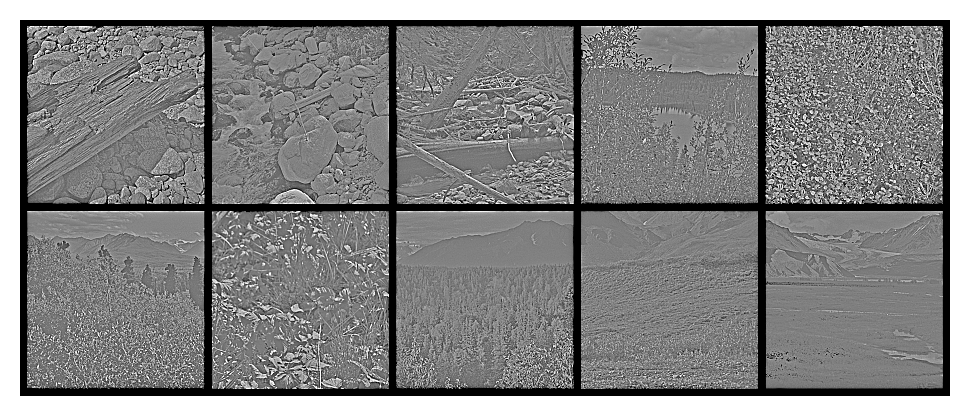

In [7]:
img_path = "path/to/IMAGES.mat"
imgs = utils.load_data(img_path)

## Problem definition
The sparse coding model is of the form 
$$ \tag{1} I(x,y) = \sum_i a_i \phi_i (x,y) + \epsilon(x,y)$$
* $I(x,y)$ denotes the pixel intensities within an image patch ($x$ and $y$ are spatial coordinates)
* $\phi_i(x, y)$ are the set of basis functions or "features" for describing the image
* $a_i$ correspond to the neural activity ($i$ denotes the index of the neuron)
* $\epsilon(x,y)$ is an additive noise term, assumed to be Gaussian

The goal is to find a dictionary of features that allow images to be described using as few non-zero $a_i$ as possible. For example, given an image patch 


one sparse reconstruction might be a weighted combination of the following features

## Energy function
To compute $a_i$ for a given image $I(x,y)$, we minimize the energy function governing the system:
$$ \tag{2} E=\frac{1}{2}\sum_{x,y}\bigg[I(x,y) - \sum_i a_i \phi_i(x,y)\bigg]^2 + \lambda\sum_i C(a)$$
* The first term measures how well information is preserved, or how well the code describes the image, defined using mean squared error between the original image patch and the reconstruction.
* The second term assesses the sparseness of the code for a given image by assigning a cost defined by $C(a)$ depending on how activity is distributed among the coefficients. Representations where activity is spread over many coefficients should incur a higher cost than those where only few coefficients carry the load.
* $\lambda$ is a positive constant that determines the importance of the second term relative to the first.

## Learning rule
How do we learn a set of basis functions $\phi$ that best accounts for the images? The most direct way is simple gradient descent on $E$ with respect to $\phi$
$$\tag{3} \Delta \phi_i(x,y) = \eta \langle a_i r(x,y)\rangle$$
* $r(x,y)$ = $I(x,y) - \sum_i a_i \phi_i(x,y)$ is the residual image
* $\eta$ is the learning rate

## Inference of sparse codes
Given our basis functions, how do we infer sparse coefficients $a_i$? The most basic method is to explicitly minimize $E$ with respect to $a_i$. This is determined from the equilibrium solution to the differential equation
$$\tag{4} \dot{a_i} = b_i - \sum_j G_{ij}a_j - \lambda C(a)$$
<!---TODO: edit this and below code to use '97 notation. Also explain why codes are sparse using this method when there is no explicit threshold?--->
* $b_i = \sum_{x,y}\phi_i(x,y) I(x,y)$
* $G_{ij} = \sum_{x,y}\phi_i(x,y)\phi_j(x,y)$


## Defining parameters
For the first pass, we suggest using the preset parameters below to make sure everything is working. After that, we recommend playing with the parameters to see how the outputs change.

In [10]:
# Tunable parameters.
epochs = 3000
num_infer_iters = 750
batch_size = 100
lambd_div_sigma = .7  # Figure 4 description.
a_lr = 1e-3
eta = 1e-3

# If nonexistent, will generate patches in next step.
patch_dir = "patches_{}".format(epochs)

# Init variables
num_bases = 64
patch_size = 8  # 8x8 image # 16x16 in paper
N = patch_size**2
torch.manual_seed(0)
rng = np.random.default_rng(seed=0)

# Sparse nonlinearity; we use |x|, but there are other possibilities.
def S(x): return torch.abs(x)  # Appears in Equation 4.
def S_prime(x): return torch.sign(x)  # Appears in Equation 5.

# For display purposes.
def loss_fn(I, Ihat, a, sigma):
    mse = F.mse_loss(Ihat, I).data  # Equation 3.
    sparseness = torch.sum(S(a/sigma))  # Equation 4.
    return mse, sparseness  # Equation 2.

# Initialize dict and visualize.
phi = torch.randn(N, num_bases)
phi = F.normalize(phi, dim=0)

Next, create patches. This will take a few minutes, but will only need to be done once (unless you increase `epochs` to be greater than `num_patches`). 

preprocessing patches; this will take a few minutes


100%|██████████| 3000/3000 [03:01<00:00, 16.54it/s]


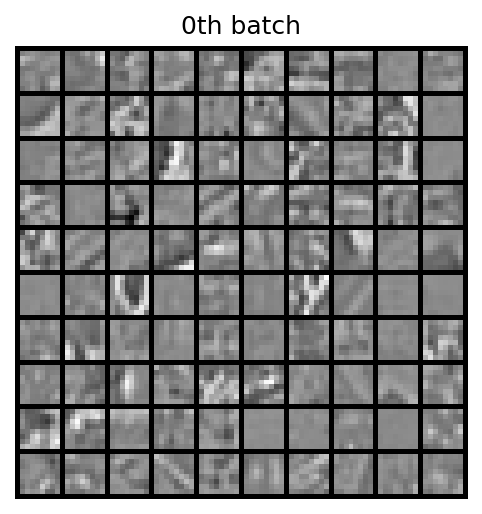

In [9]:
# Load or process patches.
num_patches = 5000
patches = utils.create_patches(imgs, num_patches, batch_size, N, patch_dir, rng)
utils.visualize_patches(patches[0, :, :], "0th batch")

## Let's run some code!
The main sparse coding algorithm consists of an outer loop that learns the dictionary features and an inner loop that infers coefficients based on the basis features.

In [13]:
# Initialize lists to store losses for plotting later.
total_losses = []
mses = []
sparse_losses = []

sigma = torch.sqrt(torch.var(patches))  # Fig. 4 description
lambd = lambd_div_sigma * sigma

for i in tqdm(range(epochs)):
    I = patches[i, :, :]
    a = torch.zeros(batch_size, num_bases)
    b = torch.mm(I, phi)  # (batch_size, num_bases)
    C = torch.mm(phi.T, phi) - torch.eye(num_bases)

    # This inner for loop uses Euler's method to learn coefficients a.
    for _ in range(num_infer_iters):
        # Obtain gradient based on Equation 5
        da = a_lr * (b - torch.mm(C, a.T).T - ((lambd_div_sigma) *
                                       S_prime(a/sigma)))  # (batch_size, num_bases)
        a += da  # (batch_size, num_bases)

    # Update basis gradients.
    Ihat = torch.mm(phi, a.T).T  # (batch_size, basis_size)
    dphi = eta * (torch.mm((I - Ihat).T, a))  # Equation 6, (basis_size, num_bases)
    phi += dphi

    # Normalize each basis to unit length.
    phi = F.normalize(phi, dim=0)

    # Calculate loss for plotting purposes.
    mse, sparseness = loss_fn(I, Ihat, a, sigma)
    total = -(-mse - lambd * sparseness) / batch_size  # Equation 2.
    total_losses.append(total)
    mses.append(mse)
    sparse_losses.append(sparseness)


100%|██████████| 3000/3000 [02:40<00:00, 18.74it/s]


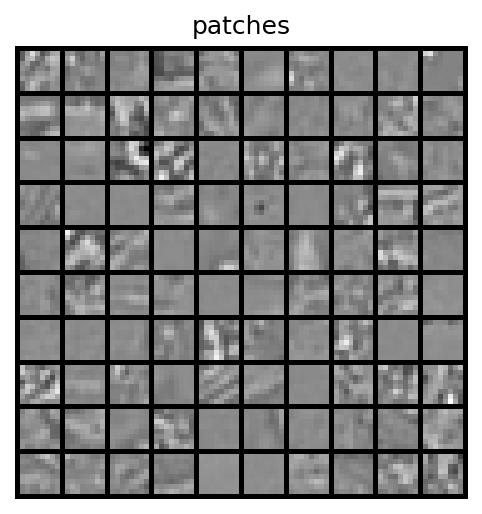

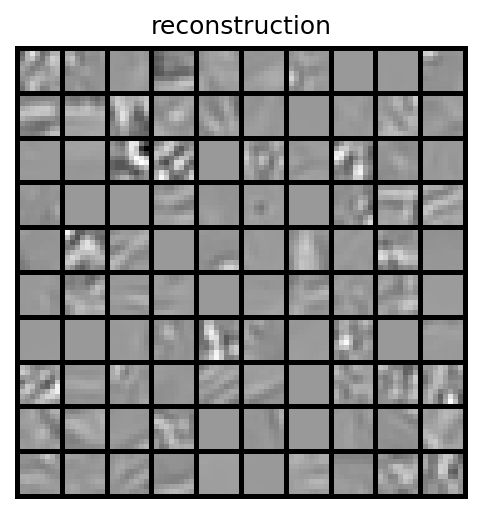

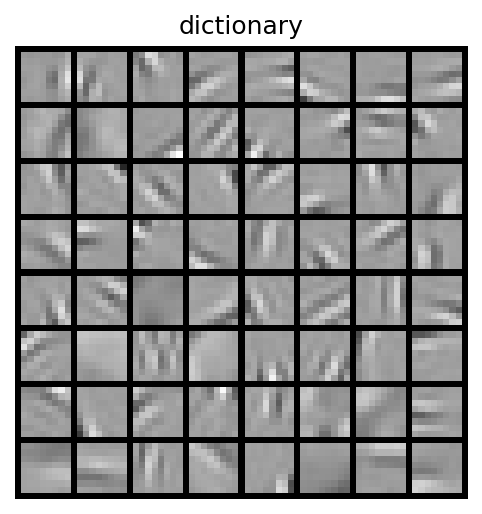

In [17]:
utils.visualize_patches(I, "patches")
utils.visualize_patches(Ihat, "reconstruction")
utils.visualize_bases(phi, "dictionary")

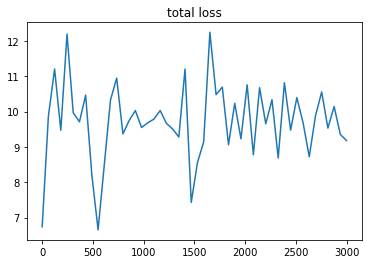

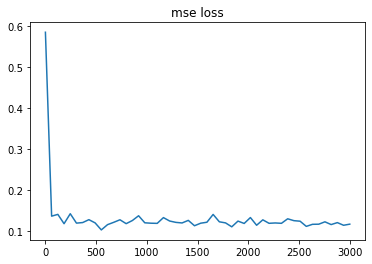

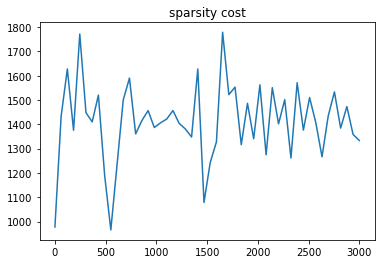

In [15]:
# Plot losses.
utils.plot_loss(total_losses, "total loss")
utils.plot_loss(mses, "mse loss")
utils.plot_loss(sparse_losses, "sparsity cost")


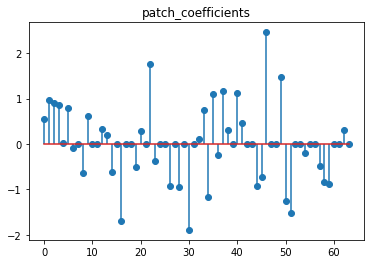

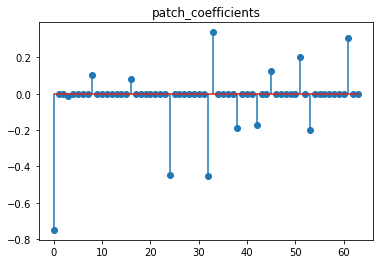

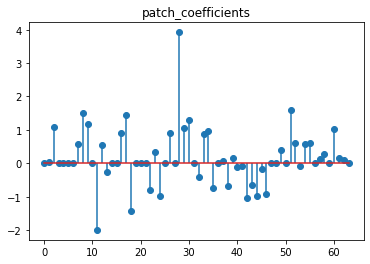

In [18]:
# Visualize the 0th, 50th, and 99th patch coefficients.
# a_sparsity = np.sum(np.array(a) == 0 * 1)/np.array(a).size
# print("sparsity: {}".format(a_sparsity))
utils.plot_coeffs(a[0])
utils.plot_coeffs(a[50])
utils.plot_coeffs(a[99])
